- https://www.teferi.net/ps/%EA%B3%A0%EC%86%8D_%ED%91%B8%EB%A6%AC%EC%97%90_%EB%B3%80%ED%99%98
- https://infograph.tistory.com/331
- https://supermemi.tistory.com/entry/Convolution%ED%95%A9%EC%84%B1%EA%B3%B1%EC%9D%98-%EC%9B%90%EB%A6%AC%EC%99%80-%EB%AA%A9%EC%A0%81

### 합성곱(Convolution)
- 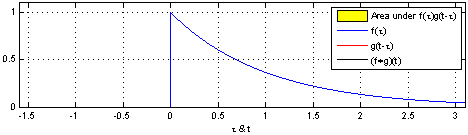
- 함수를 서로 곱해서 합한 것을 합성곱이라고 한다.

### 구현(FTT)
- 실수부의 값을 가져오기 위해서 conv의 값에는 항상 .real을 붙인뒤 round로 감싸야 한다.

In [ ]:
rt = [1]
def fft(P):
  n = len(P)
  P = list(P)
  assert n and (n - 1) & n == 0
  
  while 2 * len(rt) < n:
    import cmath
    root = cmath.exp(2j * cmath.pi / (4 * len(rt)))
    rt.extend([r * root for r in rt])

  k = n
  while k > 1:
    for i in range(n//k):
      r = rt[i]
      for j1 in range(i*k, i*k + k//2):
        j2 = j1 + k//2
        z = r * P[j2]
        P[j2] = P[j1] - z
        P[j1] = P[j1] + z
    k //= 2
  
  rev = [0] * n
  for i in range(1, n):
    rev[i] = rev[i // 2] // 2 + (i & 1) * n // 2
  return [P[r] for r in rev]

def ifft(P):
  n = len(P)
  return fft([P[-i]/n for i in range(n)])

def fft_conv(P, Q):
  m = len(P) + len(Q) - 1
  n = 1 << m.bit_length()

  P = P + [0] * (n - len(P))
  Q = Q + [0] * (n - len(Q))
  P, Q = fft(P), fft(Q)

  return ifft([p*q for p,q in zip(P, Q)])[:m]

### 구현(NTT)
- https://algoshitpo.github.io/2020/05/20/fft-ntt/
- https://cubelover.tistory.com/12
- 음수를 처리할 수 없다. 적절한 값으로 변환해야 한다.
- 매직넘버 $p$ 와 $u$ 는 모듈러 연산에 필요한 원시근(primitive root) 값의 관계이다.
  - p와 u의 조합으로 가능한 숫자들은 다음과 같다.
  - 167772161 원시근 3, cycle 2^26
  - 998244353 원시근 3, cycle 2^23
  - 2013265921 원시근 31, cycle 2^27


In [ ]:
p = 469762049
def ntt(a, inv=False):
  n = len(a)
  j = 0
  for i in range(1,n):
    rev = n >> 1
    while j >= rev:
      j -= rev
      rev >>= 1
    j += rev
    if i < j:
      a[i], a[j] = a[j], a[i]

  step = 2
  while step <= n:
    half = step // 2
    u = pow(3,p//step,p)
    if inv: u = pow(u,p-2,p)
    for i in range(0, n, step):
      w = 1
      for j in range(i, i + half):
        v = a[j + half] * w
        a[j + half] = (a[j] - v)% p
        a[j] += v
        a[j] %= p
        w *= u
        w %= p
    step *= 2

  if inv:
    invn = p - (p-1) // n
    for i in range(n):
      a[i] = (a[i] * invn)%p
  return a
    
def ntt_conv(a, b):
  s = len(a) + len(b) - 1
  n = 1 << s.bit_length()
  a += [0 for _ in range(n - len(a))]
  b += [0 for _ in range(n - len(b))]
  ntt(a)
  ntt(b)
  for i in range(n):
    a[i] *= b[i]
  ntt(a,True)
  return a